In [1]:
# refresh imports
%load_ext autoreload
%autoreload 2


# use lsdir to list files in directory models
from os import listdir
from os.path import isfile, join

mypath = "./models"
model_name = 'model_medium_20221129_211951_'
model_files = [f for f in listdir(mypath) if model_name in f]
model_files = sorted(model_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
model_files

['model_medium_20221129_211951_0.pt',
 'model_medium_20221129_211951_10.pt',
 'model_medium_20221129_211951_20.pt',
 'model_medium_20221129_211951_30.pt',
 'model_medium_20221129_211951_40.pt',
 'model_medium_20221129_211951_50.pt',
 'model_medium_20221129_211951_60.pt',
 'model_medium_20221129_211951_70.pt',
 'model_medium_20221129_211951_80.pt',
 'model_medium_20221129_211951_90.pt',
 'model_medium_20221129_211951_100.pt',
 'model_medium_20221129_211951_110.pt',
 'model_medium_20221129_211951_120.pt',
 'model_medium_20221129_211951_130.pt',
 'model_medium_20221129_211951_140.pt',
 'model_medium_20221129_211951_150.pt',
 'model_medium_20221129_211951_160.pt',
 'model_medium_20221129_211951_170.pt',
 'model_medium_20221129_211951_180.pt',
 'model_medium_20221129_211951_190.pt']

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    ElasticNet,
    LogisticRegression,
    Ridge,
    RidgeClassifier,
    SGDRegressor,
    LinearRegression,
)
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.under_sampling import RandomUnderSampler
# import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
from utils import   get_FenBatchProvider, transform
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
import pandas as pd
import sqlite3
import torch
from model_medium import DeepAutoencoder as medium_model
from small_model import DeepAutoencoder as small_model
from model import DeepAutoencoder as large_model
from scipy.special import expit

# load model from disk

activation = {}

def get_activations(model, df):
    activation_list = []

    for idx, row in tqdm(df.iterrows()):

        data = transform([row['fen']]).cuda()
        output = model(data)

        activations_ = {'index': idx}
        for k, v in activation.items():
            values = v.cpu().numpy()[0]
            if 0:
                if k in ['input_encoder_0',]:
                    # convert values to csr matrix with boolean values
                    values = csr_matrix(values, dtype=bool)
                elif k in ['decoder_3']:
                    # convert values to csr matrix with boolean values
                    values = csr_matrix(values > 0, dtype=bool)
                else:
                    # convert values to numpy float16
                    values = values.astype(np.float16)
            if k in ['decoder_3']:
                values = expit(values)
            else:
                values = values.astype(np.float16)
            
            activations_[k] = values


        # copy activation and add to activation_list
        activation_list.append(activations_.copy())

    df_activations = pd.DataFrame(activation_list)
    return df_activations


def classification_cost(y_test, y_pred):
    y_test = np.array(y_test).astype(int)
    y_pred = np.array(y_pred).astype(int)
    residuals = 1 - np.abs(y_pred - y_test)
    return np.mean(residuals) * 2 - 1
    

def train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = 0):
    results = []
    for concept_model in tqdm(concept_models):
        for input_name in tqdm(input_names):
            for target_name in target_names:

                model_name = f"{concept_model.__class__.__name__}"

                X = df_activations[input_name].tolist()
                y = df[target_name].tolist()
                #print(f"X: {input_name}, y: {target_name}, model_name: .{model_name}")

                # if X is scipy.sparse.csr_matrix, vstack it 
                if isinstance(X[0], csr_matrix):
                    X = vstack(X).astype(np.float32)
                    size = X.shape[1]
                else:
                    size = len(X[0])

                # change type of y to int
                y = np.array(y).astype(int)


                # fit and apply the transform
                X, y = undersample.fit_resample(X, y)


                # split into train and test sets 
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, random_state=42, stratify=y
                )



                concept_model.fit(X_train, list(y_train))
                y_pred = concept_model.predict(X_test)

                score = metric(y_test, y_pred)

                # calculate confusion matrix
                matrix = confusion_matrix(y_test, y_pred)

                if verbose:
                    print(f'Target value counts: {pd.Series(y_train).value_counts()}')
                    print(f'Target value counts: {pd.Series(y_test).value_counts()}')
                    print(f'input shape: {size}')
                    print(matrix)
                    print(score)

                results_ = {'model_name': model_name,
                            'input_name': input_name, 
                            'target_name': target_name,
                            'score': score, 
                            'size': size}
                results.append(results_)

    df_results = pd.DataFrame(results)
    return df_results



In [3]:
from sklearn.neural_network import MLPClassifier

test_size = 0.33
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [
    RidgeClassifier(), 
    LGBMClassifier(),
    MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter = 1000)
]
input_names = [
    'input_encoder_0', 
    'encoder_0', 
    'encoder_1', 
    'encoder_2',
    #'encoder_3',
    #'decoder_0',
    'decoder_1',
    'decoder_2',
    'decoder_3']
target_names = [
    'white_has_queen',
    'white_knight_pair',
    'white_queen_on_initial_square',
]

results = []

for model_string in model_files:

    print(f"model_name: {model_string}")

    model = medium_model(input_size = 768)
    model.load_state_dict(torch.load('models/' + model_string))

    # load df from sqlite db
    conn = sqlite3.connect('chess_auto_encoder.db')
    df = pd.read_sql_query('select * from fen_concept_df', conn)
    conn.close()

    activation = {}
    def get_output_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    def get_input_activation(name):
        def hook(model, input, output):
            activation['input_'+name] = input[0].detach()
        return hook

    model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
    model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
    model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
    model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
    #model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
    #model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
    model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
    model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
    model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

    model.cuda()

    df_activations = get_activations(model, df)




    for concept_model in concept_models:
        for input_name in input_names:
            for target_name in target_names:



                model_name = f"{concept_model.__class__.__name__}"

                X = df_activations[input_name].tolist()
                y = df[target_name].tolist()
                #print(f"X: {input_name}, y: {target_name}, model_name: .{model_name}")


                size = len(X[0])

                # change type of y to int
                y = np.array(y).astype(int)


                # fit and apply the transform
                X, y = undersample.fit_resample(X, y)


                # split into train and test sets 
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, random_state=42, stratify=y
                )



                concept_model.fit(X_train, list(y_train))
                y_pred = concept_model.predict(X_test)

                score = metric(y_test, y_pred)

                # calculate confusion matrix
                matrix = confusion_matrix(y_test, y_pred)

                if verbose:
                    print(f'Target value counts: {pd.Series(y_train).value_counts()}')
                    print(f'Target value counts: {pd.Series(y_test).value_counts()}')
                    print(f'input shape: {size}')
                    print(matrix)
                    print(score)

                results_ = {'model_name': model_name,
                            'input_name': input_name, 
                            'target_name': target_name,
                            'score': score, 
                            'size': size,
                            'model_string' : model_string,}
                results.append(results_)

df_results = pd.DataFrame(results)
# save results to pickle 
df_results.to_pickle('data/df_results_with_dnn.pkl')
df_results
print('saved results to pickle')

model_name: model_medium_20221129_211951_0.pt


38738it [00:26, 1467.67it/s]

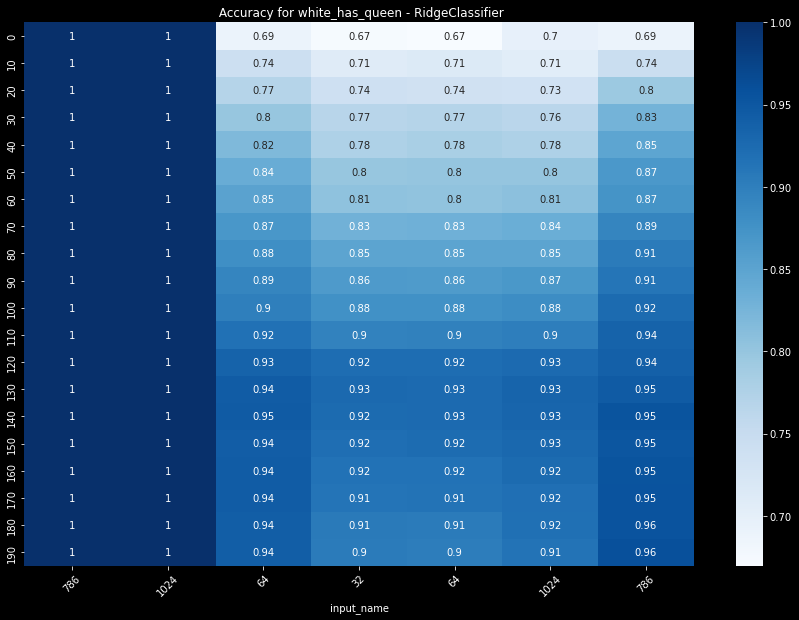

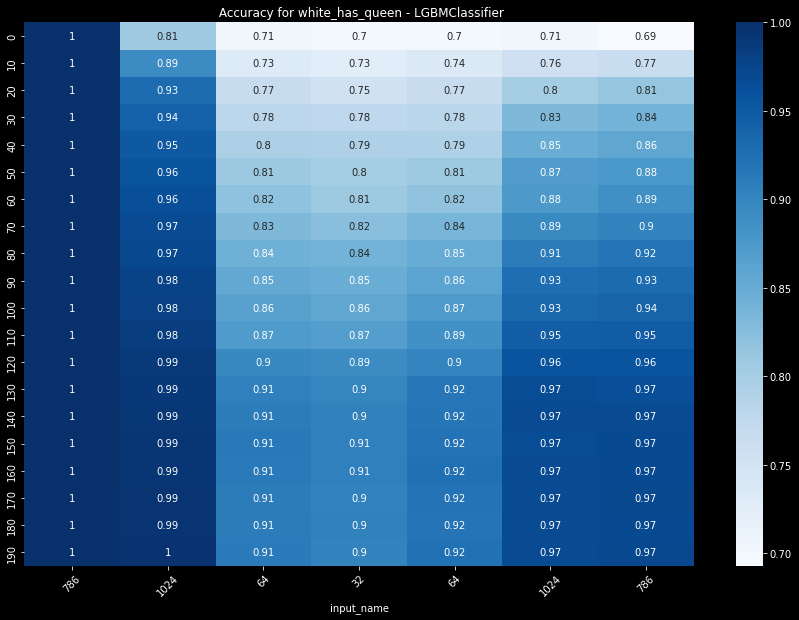

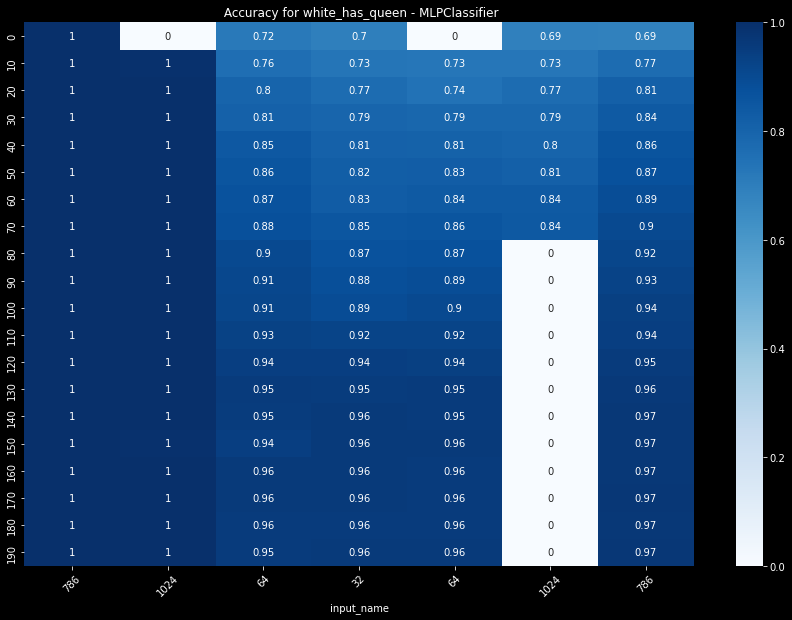

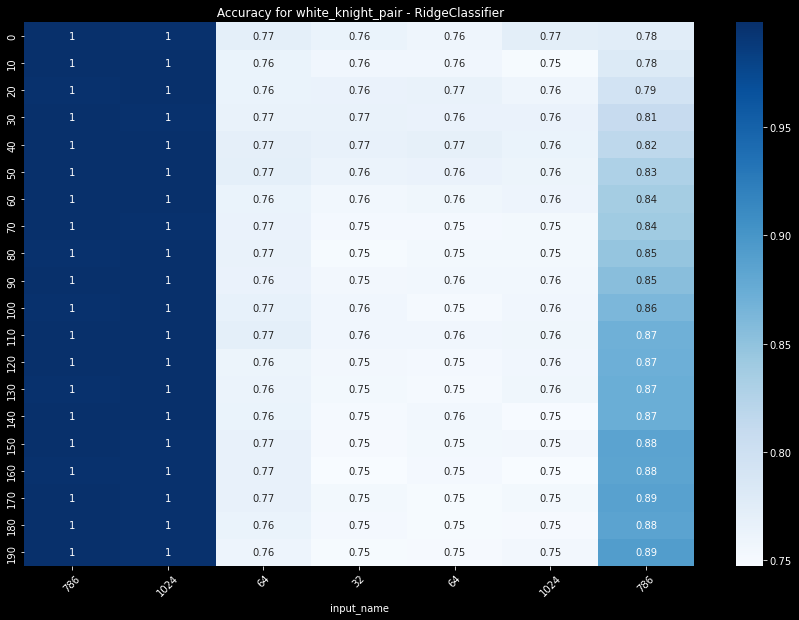

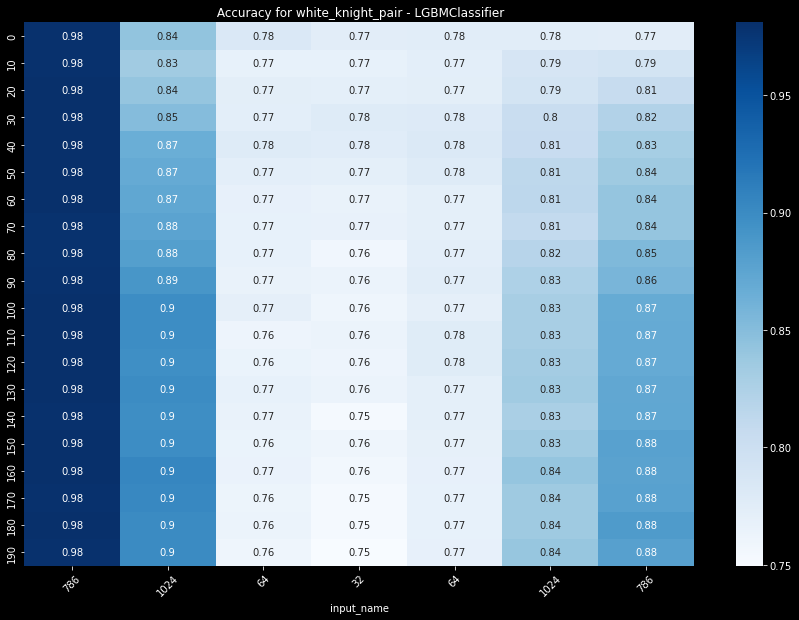

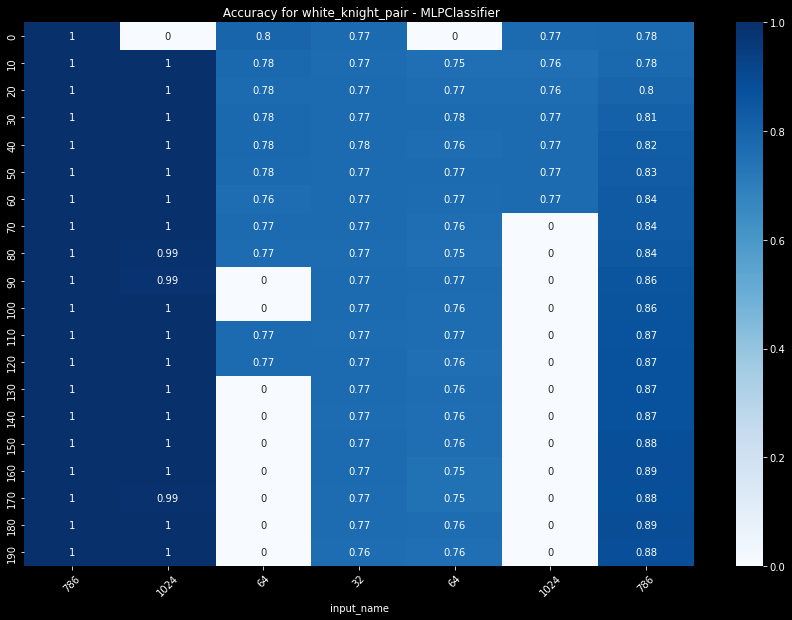

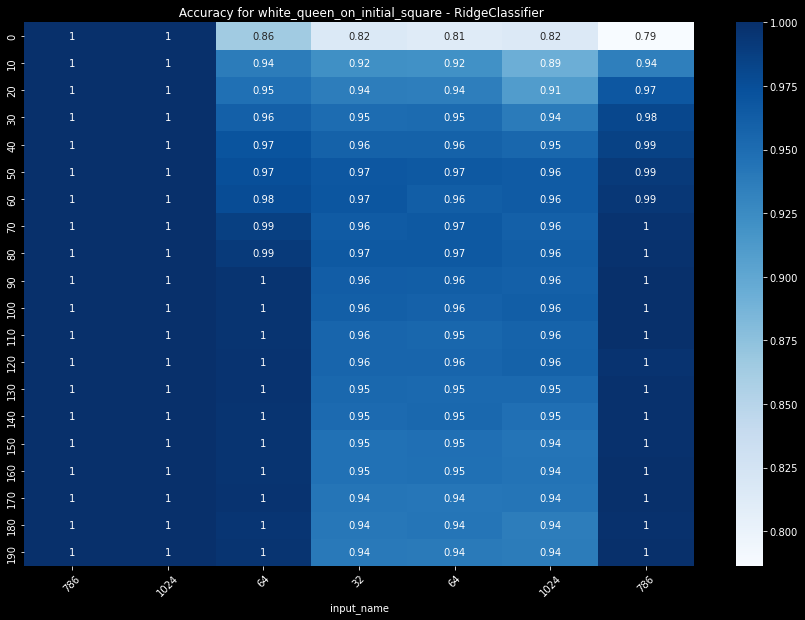

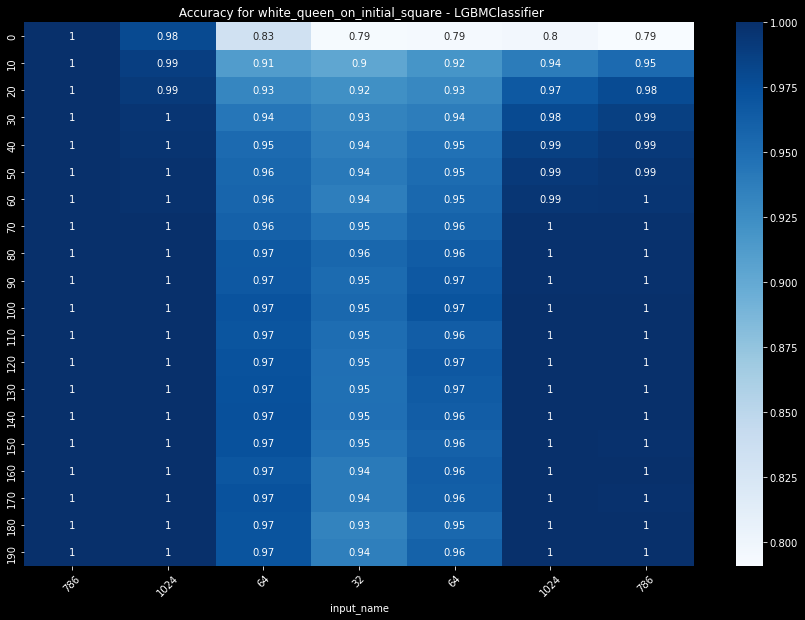

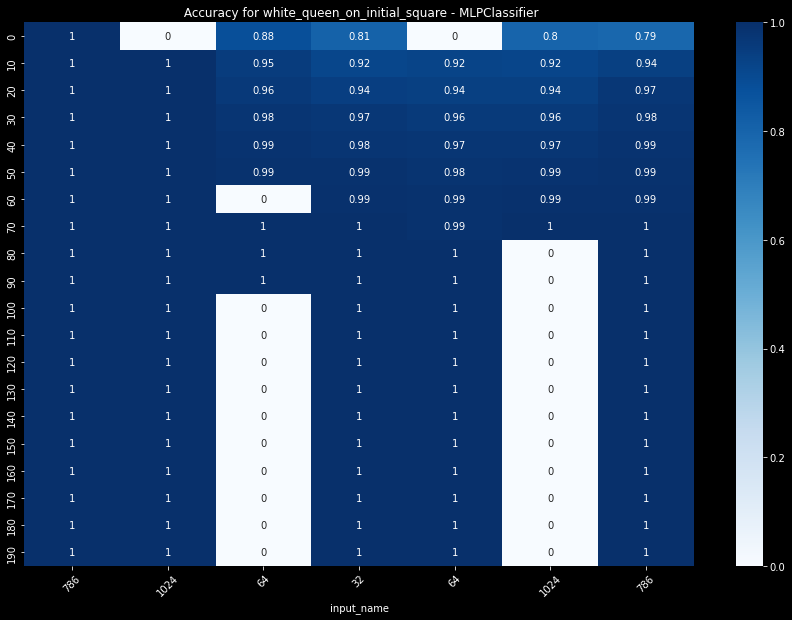

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_results = pd.read_pickle('data/df_results_with_dnn.pkl')
model_files = sorted(df_results['model_string'].unique(), key=lambda x: int(x.split('_')[-1].split('.')[0]))
# pivot table df_results with model_string as index and input_name as columns
for feature in df_results['target_name'].unique():
    for model in df_results['model_name'].unique():
        df = df_results[(df_results['target_name'] == feature) & (df_results['model_name'] == model)]
        
        df = df.pivot(index='model_string', columns='input_name', values='score')
        df = df.loc[model_files, ['input_encoder_0', 'encoder_0', 'encoder_1', 'encoder_2','decoder_1','decoder_2','decoder_3']]
        df.index = [x.split('_')[-1].split('.')[0] for x in df.index]
        plt.figure(figsize = (15,10))
        plt.title(f" Accuracy for {feature} - {model}")
        sns.heatmap(df, annot=True, cmap='Blues')       
        plt.xticks([x + 0.5 for x in range(len(df.columns))], ['786', '1024','64','32','64','1024','786'], rotation=45)
        plt.show()

In [ ]:

    df_pivot = df_results[df_results.target_name == feature].pivot_table(index='model_string', columns='input_name', values='score')
    df_pivot = df_pivot[['input_encoder_0', 'encoder_0', 'encoder_1', 'encoder_2','decoder_1','decoder_2','decoder_3']]
    df_pivot

    # plot df_pivot as heatmap
    import seaborn as sns
    plt.figure(figsize = (15,10))
    plt.title(f" Accuracy for {feature}")
    sns.heatmap(df_pivot, annot=True, cmap='Blues')

In [5]:
df_results

,model_name,input_name,target_name,score,size,model_string
0,RidgeClassifier,input_encoder_0,white_has_queen,1.000000,768,model_medium_20221129_211951_0.pt
1,RidgeClassifier,input_encoder_0,white_knight_pair,0.997366,768,model_medium_20221129_211951_0.pt
2,RidgeClassifier,input_encoder_0,white_queen_on_initial_square,1.000000,768,model_medium_20221129_211951_0.pt
3,RidgeClassifier,encoder_0,white_has_queen,1.000000,1024,model_medium_20221129_211951_0.pt
4,RidgeClassifier,encoder_0,white_knight_pair,0.997043,1024,model_medium_20221129_211951_0.pt
...,...,...,...,...,...,...
1255,MLPClassifier,decoder_2,white_knight_pair,0.000000,1024,model_medium_20221129_211951_190.pt
1256,MLPClassifier,decoder_2,white_queen_on_initial_square,0.000000,1024,model_medium_20221129_211951_190.pt
1257,MLPClassifier,decoder_3,white_has_queen,0.970872,768,model_medium_20221129_211951_190.pt
1258,MLPClassifier,decoder_3,white_knight_pair,0.883339,768,model_medium_20221129_211951_190.pt
